# Protocol for analysis of labeled proteomics data

This is the link to the github repository of the protocol 
Version: latest (still in development)
https://github.com/ProtProtocols/isolabeledprotocol
TODO add version!

Link to docker image:
_docker pull veitveit/isolabeledprotocol:latest_


## Abstract
Mass spectrometry with peptide labeling for quantification via reporter ions. Workflow based on open-source tools SearchGUI and PeptideShaker as well as in-house R scripts for further analysis using the isobar library for the extraction of reporter ions.


## Maintainer
Veit Schwämmle, veits@bmb.sdu.dk, github: veitveit
Johannes Griss, ...

## Software
Specify links for documentation and tutorials of used software, source code, publications and use cases. Detail versions of each used software. Alternatively, provide links to the software descriptions in https://bio.tools where this information is available.

- SearchGUI: https://bio.tools/searchgui, version 2.8.6
- Peptideshaker: https://bio.tools/peptideshaker, version 1.10.3
- isobar R library: https://bio.tools/isobar, version 1.24.0

## Diagram
Provide a simple diagram of functionality of the workflow/software. We recommend using controlled vocabularies for input/output data types and file formats as well as provided operation of the tool(s). You can use http://edamontology.org terms for the description.

__TODO: example__

## System requirements
Fill in the following items:
Required hard disk space for docker image, input and output files: Min. 3GB

Required memory: Min. 4GB

Recommmended number of threads: No requirement

## Example 
Presentation of well-documented instructions and commands to run the example use case. Depending on the use case and the software, provide link(s) to open the web service incorportated in the Docker image (e.g. 0.0.0.0:8080), bash commands to run programs from the command line and additional code for e.g. checking and visualizing the (intermediate) results. 

Instead of providing the instructions in this notebook, one can also provide a link to a notebook containing the example use case.

## More general use case (optional)
Provide link to notebook with a generalized use case that easily can be adapted to e.g. process different input data and concurrent parametrization.




# Example use case
The example takes the spectra from Test.mgf in the IN folder, searches them againts the human swissprot database and then carries out the quantification in R.

_Below a selection of parameters that can be modified directly:_


In [1]:
%load_ext rpy2.ipython



In [2]:
import ipywidgets as widgets
from ipywidgets import VBox, Label

w = widgets.IntSlider(min=-10,max=30,step=1,value=20)
w2 = widgets.BoundedFloatText(min=0,max=200,value=0.05)
w3 = widgets.Text("IN/sp_human.fasta")
# TODO  needs table to describe labeling formats
w4 = widgets.Dropdown(options={'TMT6': 'TMT 6-plex of K,TMT 6-plex of peptide N-term',
                               'TMT10': 'TMT 10-plex of K,TMT 10-plex of peptide N-term','iTRAQ4': 'iTRAQ 4-plex of K,iTRAQ 4-plex of Y,iTRAQ 4-plex of peptide N-term',
                               'iTRAQ8 (fixed)': 'iTRAQ 8-plex of K, iTRAQ 8-plex of peptide N-term',
                               'iTRAQ8 (variable)': 'iTRAQ 8-plex of Y'},value='TMT 10-plex of K,TMT 10-plex of peptide N-term')
w5= widgets.IntSlider(min=0,max=10,step=1,value=1)
w6 = widgets.Dropdown(options=["Carbamidomethylation of C","None"])
w7 = widgets.Dropdown(options=["None","Oxidation of M","Phosphorylation of STY"])
w8 = widgets.Text("IN/")

ww = widgets.Checkbox(description="Decoy")

display(VBox([Label('Precursor tolerance (ppm):'), w, 
              Label('Fragment ion tolerance (da):'),w2,
             Label('Fasta file (database):'),w3,
             Label('Quantification method:'),w4,
             Label('Number of miscleavages;'),w5,
             Label('Further fixed modifications'),w6,
             Label('Further variable modifications'),w7,
             Label('Folder for spectra files (files need to be mgf)'),w8]))

#TODO set names of samples and replicates (peptideshaker)


VBox(children=(Label(value='Precursor tolerance (ppm):'), IntSlider(value=20, max=30, min=-10), Label(value='Fragment ion tolerance (da):'), BoundedFloatText(value=0.05, max=200.0), Label(value='Fasta file (database):'), Text(value='IN/sp_human.fasta'), Label(value='Quantification method:'), Dropdown(index=3, options={'iTRAQ8 (fixed)': 'iTRAQ 8-plex of K, iTRAQ 8-plex of peptide N-term', 'iTRAQ4': 'iTRAQ 4-plex of K,iTRAQ 4-plex of Y,iTRAQ 4-plex of peptide N-term', 'iTRAQ8 (variable)': 'iTRAQ 8-plex of Y', 'TMT10': 'TMT 10-plex of K,TMT 10-plex of peptide N-term', 'TMT6': 'TMT 6-plex of K,TMT 6-plex of peptide N-term'}, value='TMT 10-plex of K,TMT 10-plex of peptide N-term'), Label(value='Number of miscleavages;'), IntSlider(value=1, max=10), Label(value='Further fixed modifications'), Dropdown(options=('Carbamidomethylation of C', 'None'), value='Carbamidomethylation of C'), Label(value='Further variable modifications'), Dropdown(options=('None', 'Oxidation of M', 'Phosphorylation of STY'), value='None'), Label(value='Folder for spectra files (files need to be mgf)'), Text(value='IN/')))

In [3]:
%%bash -s "$w.value" "$w2.value" "$w3.value" "$w4.value" "$w5.value" "$w6.value" "$w7.value" "$w7.value"
function check_error {
    RETURN_CODE="$1"
    MSG="$2"

    if [ "${RETURN_CODE}" != "0" ]; then
        echo "Error: $MSG"
        exit 1
    fi
}
cd OUT
java -cp /home/biodocker/bin/SearchGUI-*/SearchGUI-*.jar eu.isas.searchgui.cmd.FastaCLI -in "../$3" -decoy

check_error $? "Failed to create decoy database"

DECOY_FASTA="../${3%.*}_concatenated_target_decoy.fasta"
echo $DECOY_FASTA

if [ ! -e ${DECOY_FASTA} ]; then
    echo "Failed to create decoy database"
    exit 1
fi

VAR_MODS=""
if [ $7 != "None" ]; then
    VAR_MODS="-variable_mods $7"
fi

# ---- create parameter file for SearchGUI ----
java -cp /home/biodocker/bin/SearchGUI-*/SearchGUI-*.jar \
eu.isas.searchgui.cmd.IdentificationParametersCLI -prec_tol $1 -frag_tol $2 \
-fixed_mods "$4,$6"  $VAR_MODS  -db "${DECOY_FASTA}" -out search.par -mc $5

check_error $? "Failed to create parameter file"

if [ ! -e "search.par" ]; then
    echo "Failed to create search parameters"
    exit 1
fi



Reindexing: sp_human.fasta.
10% 20% 30% 40% 50% 60% 70% 80% 90%Input: /home/biodocker/OUT/../IN/sp_human.fasta

Name: sp_human
Version: 23.1.2018
Decoy Tag: null
Type: UniProt
Last modified: Tue Jan 23 08:00:09 UTC 2018
Size: 20243 sequences


Tue Jan 23 08:10:16 UTC 2018 Appending Decoy Sequences. Please Wait...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100%Reindexing: sp_human_concatenated_target_decoy.fasta.

10% 20% 30% 40% 50% 60% 70% 80% 90%Decoy file successfully created: 

Output: /home/biodocker/OUT/../IN/sp_human_concatenated_target_decoy.fasta

Name: sp_human_concatenated_target_decoy
Version: 23.1.2018
Decoy Tag: REVERSED
Type: UniProt
Last modified: Tue Jan 23 08:10:21 UTC 2018
Size: 40486 sequences (20243 target)

../IN/sp_human_concatenated_target_decoy.fasta

Identification parameters file created: /home/biodocker/OUT/search.par



In [4]:
%%bash -s "$w8.value"
function check_error {
    RETURN_CODE="$1"
    MSG="$2"

    if [ "${RETURN_CODE}" != "0" ]; then
        echo "Error: $MSG"
        exit 1
    fi
}
FILE_LIST=$(ls $1)
echo $FILE_LIST
cd OUT

# Run Search
java -cp /home/biodocker/bin/SearchGUI-*/SearchGUI-*.jar eu.isas.searchgui.cmd.SearchCLI \
-spectrum_files ../$1  -output_folder ./  -id_params search.par -xtandem 0 -msgf 1 \
-comet 0 -ms_amanda 0 -myrimatch 0 -andromeda 0 -omssa 0 -tide 0
check_error $? "Search failed."


sp_human.fasta sp_human.fasta.cui sp_human_concatenated_target_decoy.fasta sp_human_concatenated_target_decoy.fasta.cui test.mgf
Tue Jan 23 08:10:38 UTC 2018 Validating MGF file: /home/biodocker/OUT/../IN/test.mgf
10% 20% 30% 40% 50% 60% 70% 80% 90%

Tue Jan 23 08:10:45 UTC 2018 Indexing spectrum files.
Tue Jan 23 08:10:45 UTC 2018 Extracting search settings.



Processing: test.mgf (1/1)


ms-gf+ command: 
/usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java -jar /home/biodocker/bin/SearchGUI-2.8.6/resources/MS-GF+/MSGFPlus.jar -s /home/biodocker/OUT/../IN/test.mgf -d /home/biodocker/OUT/../IN/sp_human_concatenated_target_decoy.fasta -o /home/biodocker/OUT/./.SearchGUI_temp/test.msgf.mzid -t 20.0ppm -tda 0 -mod /home/biodocker/bin/SearchGUI-2.8.6/resources/MS-GF+/params/Mods.txt -minCharge 2 -maxCharge 4 -inst 3 -thread 1 -m 3 -e 1 -ntt 2 -protocol 0 -minLength 8 -maxLength 30 -n 10 -addFeatures 0 -ti 0,1 

Tue Jan 23 08:10:45 UTC 2018 Processing test.mgf with MS-GF+.

MS-GF+ Beta (v10282) 

In [5]:
#TODO, some visualizations + numbers (e.g. number of spectra, ...)

In [3]:
%%bash -s "$w8.value"
function check_error {
    RETURN_CODE="$1"
    MSG="$2"

    if [ "${RETURN_CODE}" != "0" ]; then
        echo "Error: $MSG"
        exit 1
    fi
}

cd OUT
ls

# ---- PeptideShaker ----
java -Xmx4G  -cp /home/biodocker/bin/PeptideShaker-*/PeptideShaker-*.jar \
eu.isas.peptideshaker.cmd.PeptideShakerCLI -experiment experiment1 \
-sample test -replicate 1 -identification_files './'  -out ./experiment.cpsx \
-id_params search.par -spectrum_files  "../$1"

check_error $? "Failed to run PeptideShaker"

java -cp /home/biodocker/bin/PeptideShaker-*/PeptideShaker-*.jar \
eu.isas.peptideshaker.cmd.ReportCLI -in "experiment.cpsx" -out_reports "./" -reports "8"


SearchGUI Report 2018-01-23 08.16.32.html
derby.log
hs_err_pid82.log
resources
search.par
searchgui_out.zip
Tue Jan 23 12:15:45 UTC 2018 Unzipping searchgui_out.zip.
10% 20% 30% 40% 50% 60% 70% 80% 90% 100%

Tue Jan 23 12:15:45 UTC 2018 Import process for experiment1 (Sample: test, Replicate: 1)

Tue Jan 23 12:15:46 UTC 2018 Importing sequences from sp_human_concatenated_target_decoy.fasta.
Tue Jan 23 12:15:57 UTC 2018 Estimated import time: 5 minutes.
Tue Jan 23 12:15:57 UTC 2018     See http://compomics.github.io/compomics-utilities/wiki/proteininference.html.
10% 20% 30% 40% 50%
Tue Jan 23 12:21:29 UTC 2018 FASTA file import completed.
Tue Jan 23 12:21:29 UTC 2018 Importing gene mappings.
Tue Jan 23 12:21:30 UTC 2018 Establishing local database connection.
Tue Jan 23 12:21:35 UTC 2018 Reading identification files.
Tue Jan 23 12:21:35 UTC 2018 Parsing test.msgf.mzid.
10% 20% 30% 40% 50% 60% 70% 80% 90% 100%
Tue Jan 23 12:21:35 UTC 2018 Loading spectra for test.msgf.mzid.
Tue Jan 23 1

java.lang.IllegalArgumentException: Database import was not successfully completed. Database will be reindexed.
	at com.compomics.util.experiment.identification.protein_inference.proteintree.ProteinTree.initiateTree(ProteinTree.java:258)
	at com.compomics.util.experiment.identification.protein_inference.proteintree.ProteinTree.initiateTree(ProteinTree.java:205)
	at com.compomics.util.experiment.identification.protein_sequences.SequenceFactory.getDefaultPeptideMapper(SequenceFactory.java:1391)
	at com.compomics.util.experiment.identification.protein_sequences.SequenceFactory.getDefaultPeptideMapper(SequenceFactory.java:1313)
	at eu.isas.peptideshaker.fileimport.FileImporter.importSequences(FileImporter.java:210)
	at eu.isas.peptideshaker.fileimport.FileImporter$IdProcessorFromFile.importFiles(FileImporter.java:448)
	at eu.isas.peptideshaker.fileimport.FileImporter.importFiles(FileImporter.java:156)
	at eu.isas.peptideshaker.PeptideShaker.importFiles(PeptideShaker.java:232)
	at eu.isas.p

[1] "Loaded 445 PSMs"
[1] "Filtered 11 PSMs @ 0.01 FDR"
  reading id file t.corr.csv [type: ibspectra] ... done
  reading mgf file IN/test.mgf [fragment precision: 0.05]
  1504 spectra in MGF file.
 data.frame columns OK
Creating ProteinGroup ... done
 for 565 spectra [98.09%], quantitative information is available,
   but no peptide-spectrum match. Spectrum titles: 
	20170424_Lumos_RSLC3_Maurer_Hartl_UW_MFPL_shotgun_TMT1_global_Fr10.27.2,
	20170424_Lumos_RSLC3_Maurer_Hartl_UW_MFPL_shotgun_TMT1_global_Fr10.29.4, ...
LOG: isotopeImpurities.corrected: TRUE
LOG: is.normalized: TRUE
	normalizing test.mgf [11 spectra]
LOG: normalization.multiplicative.factor file test.mgf channel 126: 0.7966
LOG: normalization.multiplicative.factor file test.mgf channel 127N: 0.7722
LOG: normalization.multiplicative.factor file test.mgf channel 127C: 0.6192
LOG: normalization.multiplicative.factor file test.mgf channel 128N: 0.8455
LOG: normalization.multiplicative.factor file test.mgf channel 128C: 0.3353


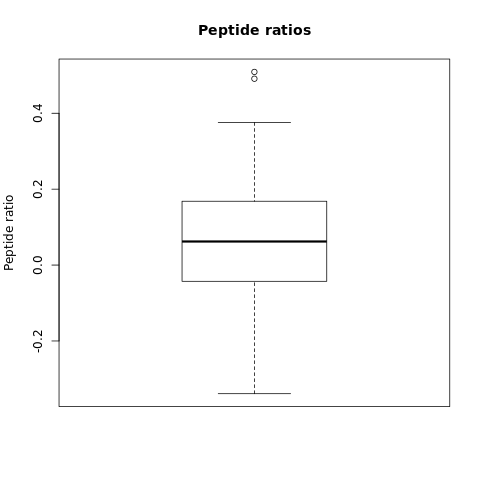

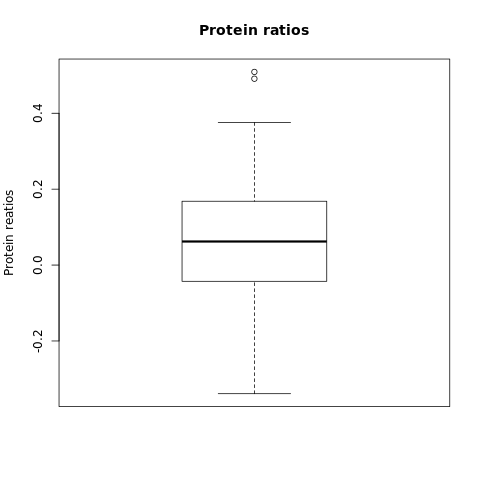

In [8]:
%%R 

suppressPackageStartupMessages(library(isobar))
sink(stdout(),type="message")

# library causes the execution to fail if the library is missing
library(isobar)

# TODO load parameters "%%R -i parname"
# process the input files
max.fdr <- 0.01
quant.method <- "TMT10plexSpectra"
class.labels <- c("A", "B", "C", "D", "E", "F", "G", "H", "I", "J")
args <- commandArgs(trailingOnly = TRUE)

ident.file <- "OUT/experiment1_test_1_Extended_PSM_Report.txt"
mgf.files <- system("ls IN/*.mgf", intern=T)

if (!file.exists(ident.file)) {
    stop("Error: Cannot find identification file ", ident.file)
}
for (mgf.file in mgf.files) {
    if (!file.exists(mgf.file)) {
        stop("Error: Cannot find MGF file ", mgf.file)
    }
}

# Convert SearchGUI output to isobar format
psms <- read.csv(ident.file, sep = "\t")

if (! "Decoy" %in% names(psms)) {
    stop("Error: No decoy information available in output file")
}

print(paste("Loaded",nrow(psms), "PSMs"))

# ---- Confidence filter ----
psms <- psms[order(psms[, "Confidence...."], decreasing = T), ]
decoy.psms <- which(psms[, "Decoy"] == "1")

decoy.count <- 0

for (decoy.index in decoy.psms) {
    decoy.count <- decoy.count + 1
    target.count <- decoy.index - decoy.count

    cur.fdr <- (decoy.count * 2) / (decoy.count + target.count)

    if (cur.fdr > max.fdr) {
        # filter
        psms <- psms[1:decoy.index - 1,]
        break
    }
}

# print(head(psms))

print(paste0("Filtered ", nrow(psms), " PSMs @ ", max.fdr, " FDR"))

# ---- convert to isobar output ----
cols.to.save <- c("Protein.s.", "Sequence", "Spectrum.Title", "Variable.Modifications", "Confidence....", "D.score", "Validation", "Precursor.m.z.Error..ppm.", "Spectrum.File")

if (!all(cols.to.save %in% colnames(psms))) {
    stop("Error: Unexpected result format")
}

psms <- psms[, cols.to.save]
colnames(psms) <- c("accession", "peptide", "spectrum", "var_mod", "pepscore", "dscore", "validation", 
"precursor.mz.error.ppm", "file")

# TODO: add modif...
psms$modif <- ""

write.table(psms, file = "t.corr.csv", sep = "\t", row.names = F, quote = F)

# ---- isobar workflow ----
ib <- readIBSpectra(quant.method, "t.corr.csv", mgf.files, decode.titles = T)

ib <- correctIsotopeImpurities(ib)
ib <- normalize(ib)
noise.model <- NoiseModel(ib)

# Extract peptide and protein ratios
protein.ratios <- proteinRatios(ib, noise.model, combn.method = "versus.channel", cl = class.labels)
peptide.ratios <- peptideRatios(ib, noise.model, combn.method = "versus.channel", cl = class.labels)

boxplot(peptide.ratios$lratio, main = "Peptide ratios", ylab = "Peptide ratio")
boxplot(protein.ratios$lratio, main = "Protein ratios", ylab = "Protein reatios")

# save the ratios for later use
saveRDS(protein.ratios, file = "OUT/protein.ratios.rds")
saveRDS(peptide.ratios, file = "OUT/peptide.ratios.rds")